In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Introducción a las GANS
## Redes Genarivas Adversarias
### Posgrado en ciencias e ingeniería en computación UNAM


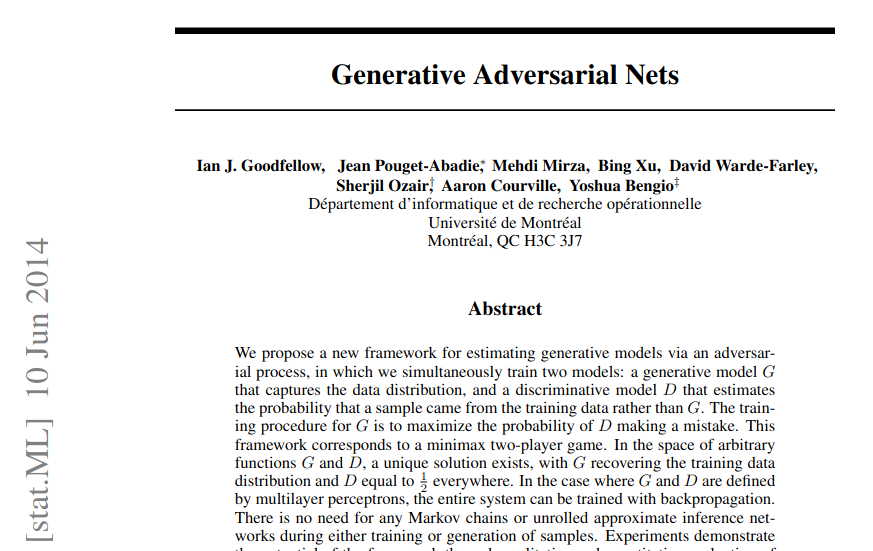




## ¿Qué son?

Arquitecturas de aprendizaje profundo diseñadas para generar datos sintéticos que traten de ser realistas, como imágenes, audio o texto.

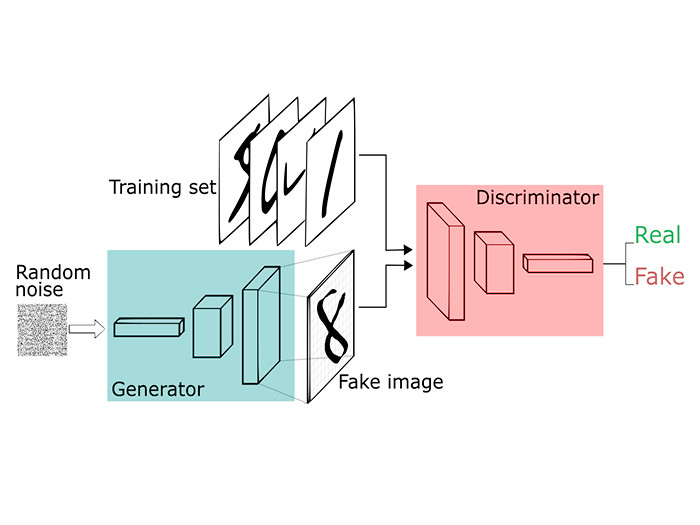

## Generador


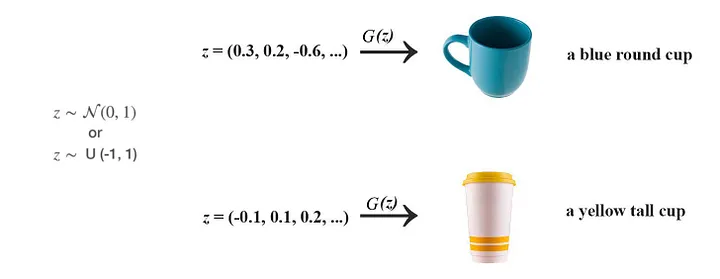


**Resultados**

(Ya entrenado)


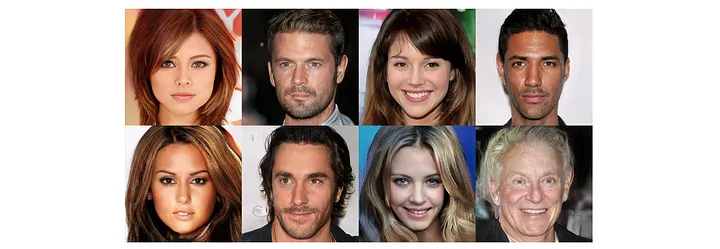

**Moviendole al vector z**

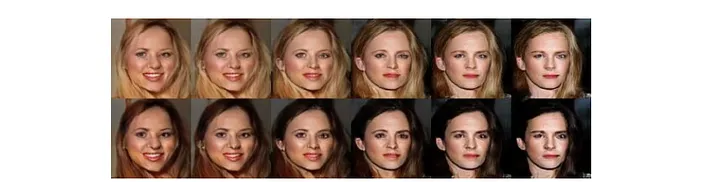

**Tareas de las GANs**


    Crear imagenes desde 0 (Crear Rostros)
    Crear imagenes apartir de eiquetas
    Transferencia de estilo
    Super-resolución
    Traducción de dominio
    Interpolación de estilos
    ... Entre otras



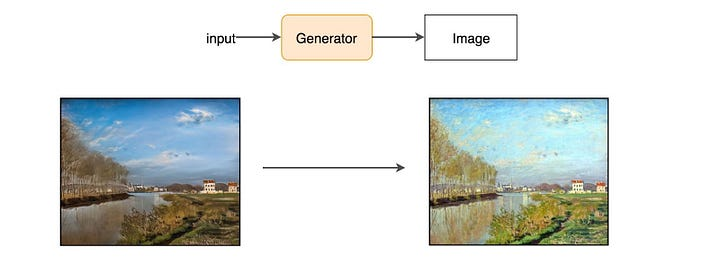

In [ ]:
latent_dim = 100
num_classes = 10
img_shape = (1, 28, 28)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

**Pero, es necesario algo que evalue**



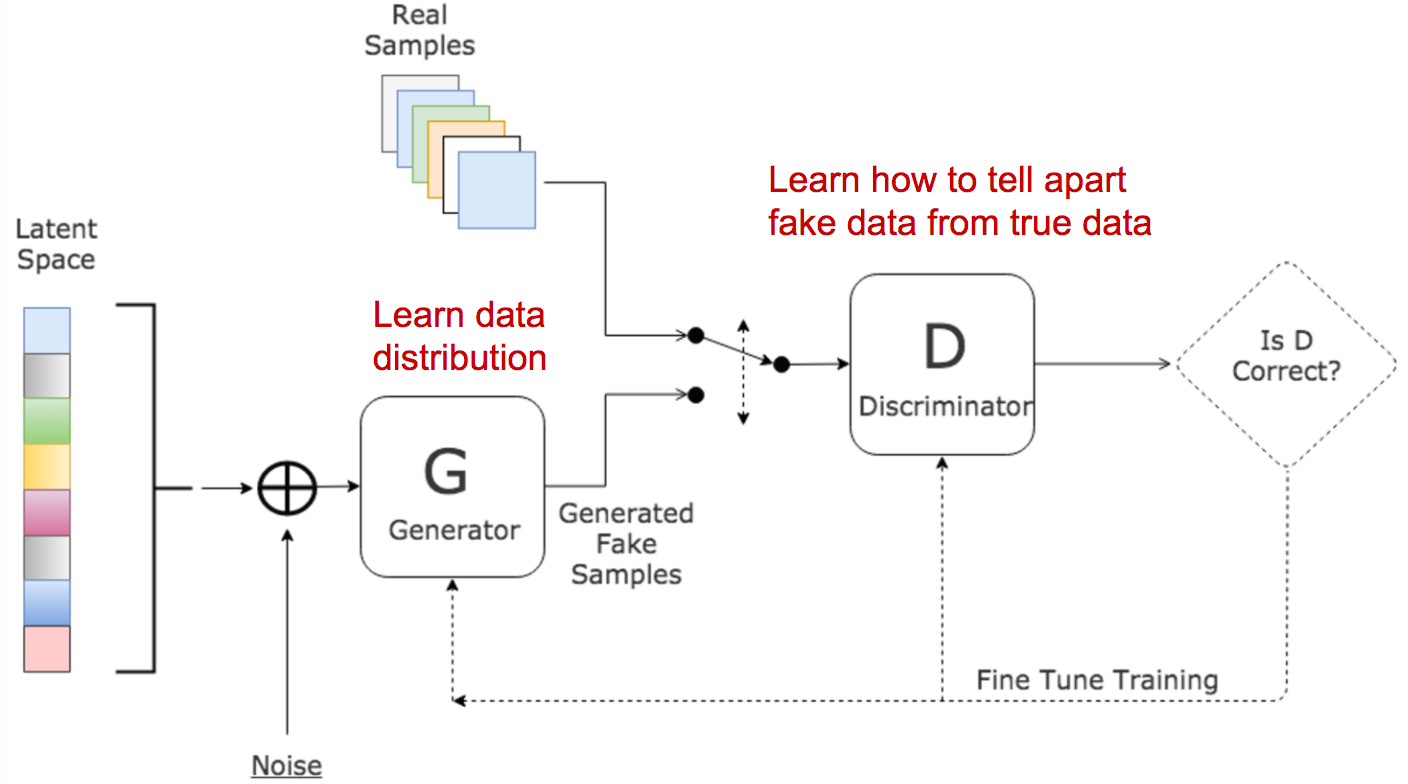

## Discriminador

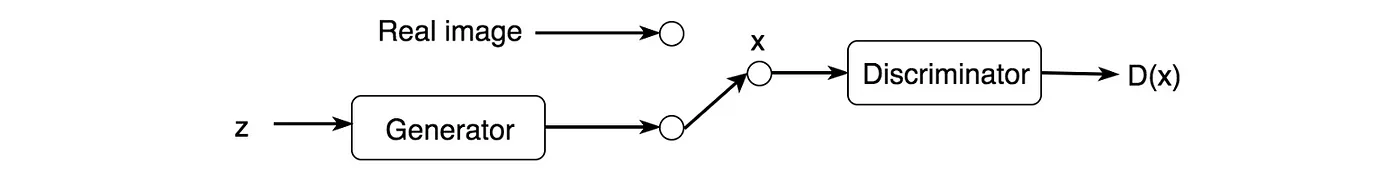

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

## Entrenamiento

### Discriminador

 El discriminador produce un valor D(x) indicando la posibilidad de que x sea una imagen real. Nuestro objetivo es maximizar la oportunidad de reconocer imágenes reales como imágenes reales y generadas como falsas, es decir, la máxima probabilidad de los datos observados.

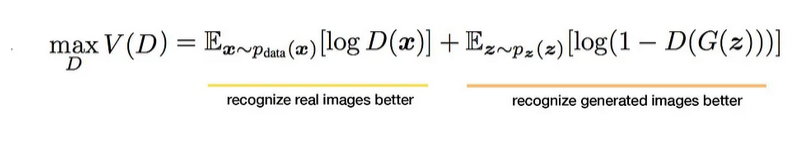




### Generador

En el lado del generador, su función objetiva quiere que el modelo genere imágenes con el mayor valor posible de D(x) para engañar al discriminador

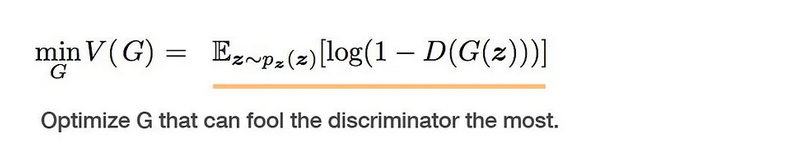

A menudo definimos GAN como un juego minimax donde G quiere minimizar V,  mientras que D quiere maximizarlo.

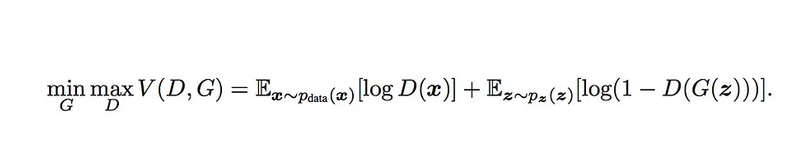

Se entrena por pasos,

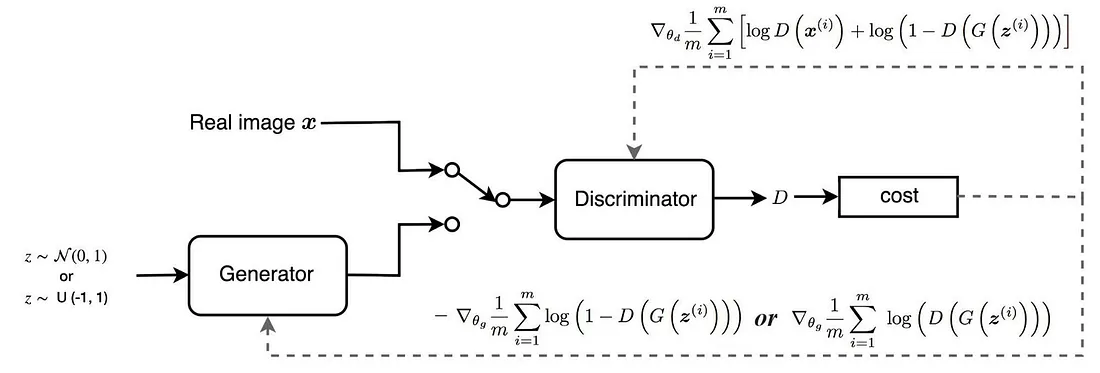

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
G_opt = optim.Adam(G.parameters(), lr=lr)
D_opt = optim.Adam(D.parameters(), lr=lr)

def train_gan(epochs=20):
    for epoch in range(epochs):
        for real, _ in dataloader:
            real = real.to(device)
            batch_size = real.size(0)

            # Entrenar discriminador
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake = G(noise)
            D_loss = (
                loss_fn(D(real), torch.ones(batch_size, 1, device=device)) +
                loss_fn(D(fake.detach()), torch.zeros(batch_size, 1, device=device))
            ) / 2
            D_opt.zero_grad()
            D_loss.backward()
            D_opt.step()

            # Entrenar generador
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake = G(noise)
            G_loss = loss_fn(D(fake), torch.ones(batch_size, 1, device=device))
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

In [ ]:
def show_generated_images():
    G.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim, device=device)
        samples = G(z)
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Imágenes generadas")
        plt.show()

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

def combined_latent_visualization(n_samples=200, n_examples=10):
    G.eval()
    with torch.no_grad():
        # Paso 1: generar vectores latentes y etiquetas
        z = torch.randn(n_samples, latent_dim).to(device)
        labels = torch.randint(0, num_classes, (n_samples,), device=device)

        # Paso 2: generar imágenes
        gen_imgs = G(z).cpu()
        z_cpu = z.cpu()
        labels_cpu = labels.cpu()

        # Paso 3: PCA
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z_cpu)

        # Paso 4: Graficar espacio latente con colores por clase
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels_cpu, cmap='tab10', s=20)
        plt.colorbar(scatter, ticks=range(num_classes), label='Clase')
        plt.title("Espacio latente proyectado (PCA)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.show()

        # Paso 5: Mostrar ejemplos individuales con punto + imagen generada
        fig, axs = plt.subplots(n_examples, 2, figsize=(6, n_examples * 2))

        example_idxs = torch.linspace(0, n_samples-1, n_examples).long()

        for i, idx in enumerate(example_idxs):
            idx = idx.item()
            axs[i, 0].scatter(z_pca[idx, 0], z_pca[idx, 1], c='red', s=100)
            axs[i, 0].set_xlim(z_pca[:, 0].min()-1, z_pca[:, 0].max()+1)
            axs[i, 0].set_ylim(z_pca[:, 1].min()-1, z_pca[:, 1].max()+1)
            axs[i, 0].set_title(f'z → Clase {labels_cpu[idx].item()}')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(gen_imgs[idx][0], cmap='gray')
            axs[i, 1].set_title("Imagen generada")
            axs[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
from torchinfo import summary

print("Generador:")
print(G)
summary(G, input_size=(1, latent_dim))

print("\nDiscriminador:")
summary(D, input_size=(1, 1, 28, 28))

Generador:
Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Discriminador:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 512]                  401,920
│    └─LeakyReLU: 2-3                    [1, 512]                  --
│    └─Linear: 2-4                       [1, 256]                  131,328
│    └─LeakyReLU: 2-5                    [1, 256]                  --
│    └─Linear: 2-6                       [1, 1]                    257
│    └─Sigmoid: 2-7                      [1, 1]                    --
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.13
Estimated Total Size (MB): 2.14

Epoch 1/20 | D Loss: 0.0439 | G Loss: 6.7317
Epoch 2/20 | D Loss: 0.0255 | G Loss: 11.5668
Epoch 3/20 | D Loss: 0.5019 | G Loss: 4.0165
Epoch 4/20 | D Loss: 0.9758 | G Loss: 1.0859
Epoch 5/20 | D Loss: 0.3693 | G Loss: 2.6522
Epoch 6/20 | D Loss: 0.7739 | G Loss: 1.3646
Epoch 7/20 | D Loss: 0.3984 | G Loss: 1.4155
Epoch 8/20 | D Loss: 0.1746 | G Loss: 2.3729
Epoch 9/20 | D Loss: 0.6442 | G Loss: 1.2684
Epoch 10/20 | D Loss: 0.7316 | G Loss: 1.4237
Epoch 11/20 | D Loss: 0.6545 | G Loss: 1.2191
Epoch 12/20 | D Loss: 0.3745 | G Loss: 1.6082
Epoch 13/20 | D Loss: 0.5620 | G Loss: 1.9567
Epoch 14/20 | D Loss: 0.6971 | G Loss: 1.4397
Epoch 15/20 | D Loss: 0.3517 | G Loss: 2.2555
Epoch 16/20 | D Loss: 0.1663 | G Loss: 2.4448
Epoch 17/20 | D Loss: 0.2048 | G Loss: 3.4151
Epoch 18/20 | D Loss: 0.5738 | G Loss: 2.2450
Epoch 19/20 | D Loss: 0.3431 | G Loss: 3.4113
Epoch 20/20 | D Loss: 0.3619 | G Loss: 2.5516


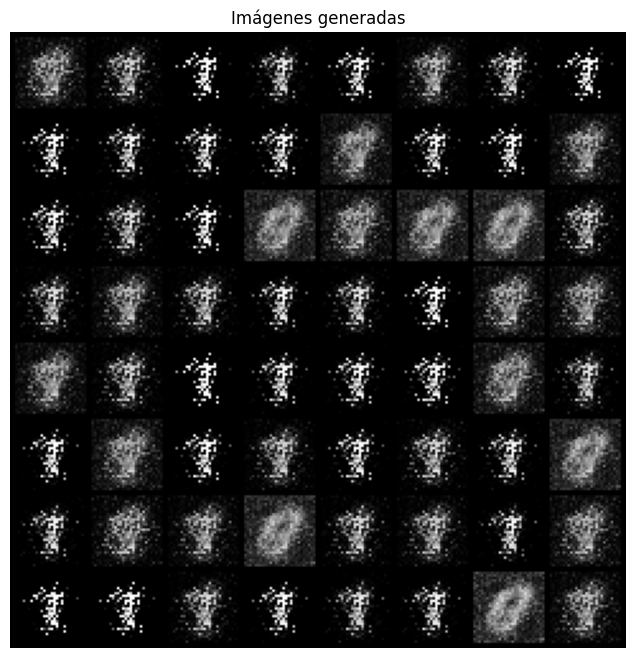

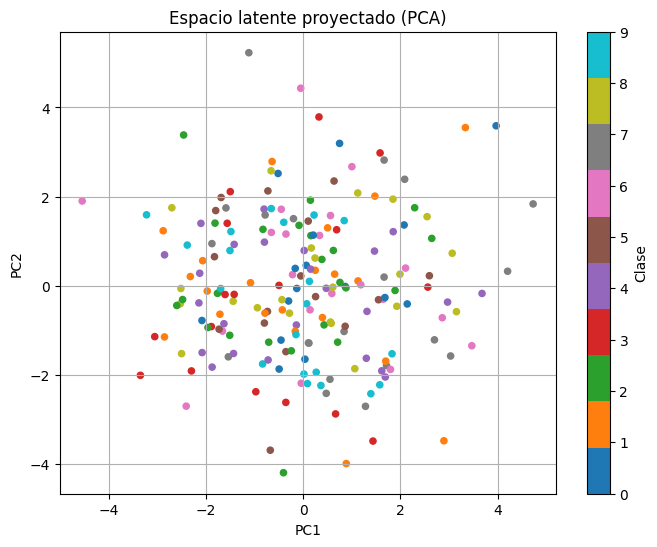

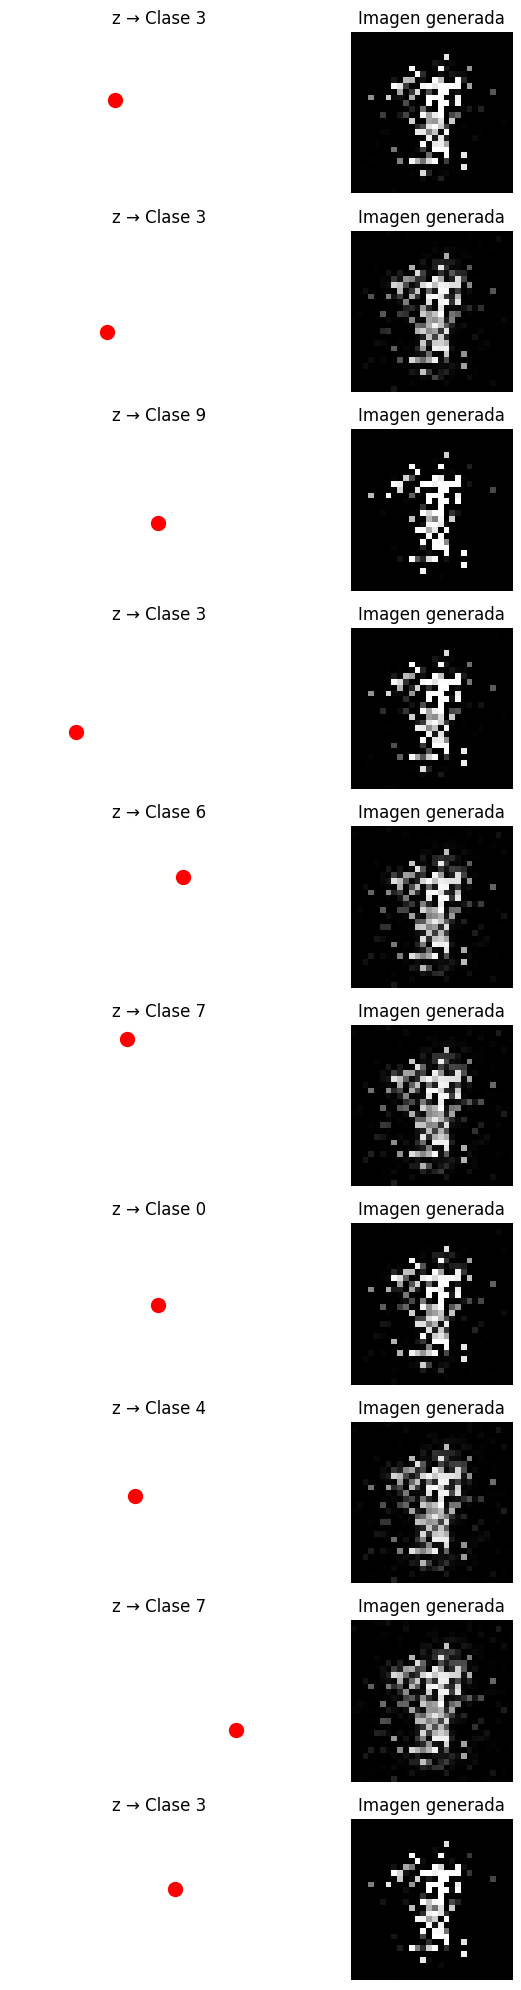

In [ ]:
train_gan(epochs=20)
show_generated_images()
combined_latent_visualization(n_samples=200, n_examples=10)

Epoch 1/50 | D Loss: 0.0356 | G Loss: 5.5328
Epoch 2/50 | D Loss: 0.0382 | G Loss: 7.3310
Epoch 3/50 | D Loss: 0.1909 | G Loss: 5.9781
Epoch 4/50 | D Loss: 1.1584 | G Loss: 1.3581
Epoch 5/50 | D Loss: 0.2026 | G Loss: 3.2740
Epoch 6/50 | D Loss: 0.3401 | G Loss: 3.8774
Epoch 7/50 | D Loss: 0.5627 | G Loss: 1.7197
Epoch 8/50 | D Loss: 0.3706 | G Loss: 3.4309
Epoch 9/50 | D Loss: 0.3400 | G Loss: 2.6452
Epoch 10/50 | D Loss: 0.3169 | G Loss: 2.3485
Epoch 11/50 | D Loss: 0.2106 | G Loss: 3.9868
Epoch 12/50 | D Loss: 0.2650 | G Loss: 3.1759
Epoch 13/50 | D Loss: 0.1897 | G Loss: 2.8820
Epoch 14/50 | D Loss: 0.3145 | G Loss: 3.3118
Epoch 15/50 | D Loss: 0.2587 | G Loss: 3.1433
Epoch 16/50 | D Loss: 0.2166 | G Loss: 4.3808
Epoch 17/50 | D Loss: 0.0946 | G Loss: 4.7822
Epoch 18/50 | D Loss: 0.3583 | G Loss: 4.5267
Epoch 19/50 | D Loss: 0.1496 | G Loss: 4.5678
Epoch 20/50 | D Loss: 0.1282 | G Loss: 5.1799
Epoch 21/50 | D Loss: 0.1856 | G Loss: 4.4531
Epoch 22/50 | D Loss: 0.2643 | G Loss: 3.24

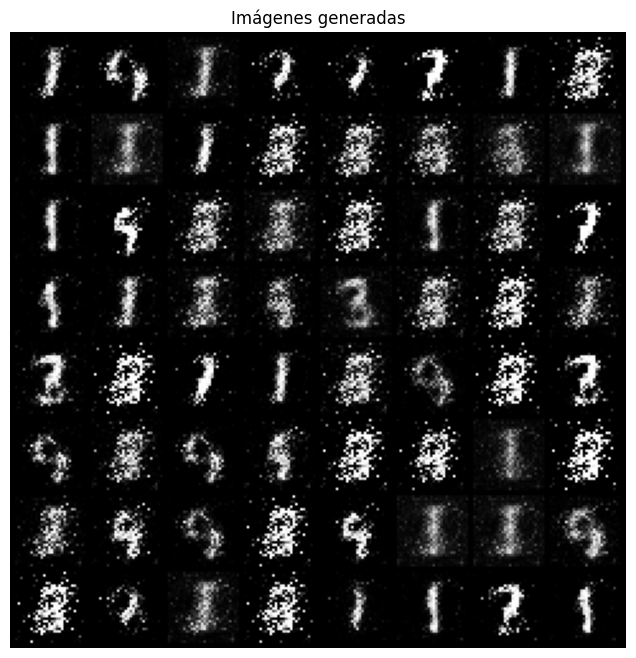

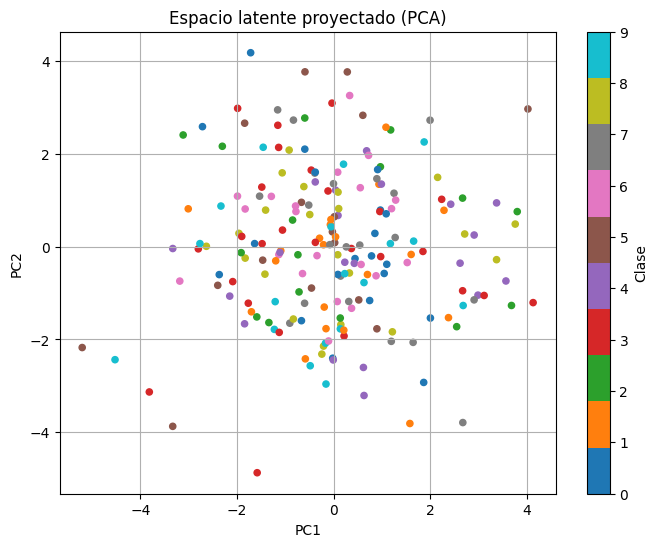

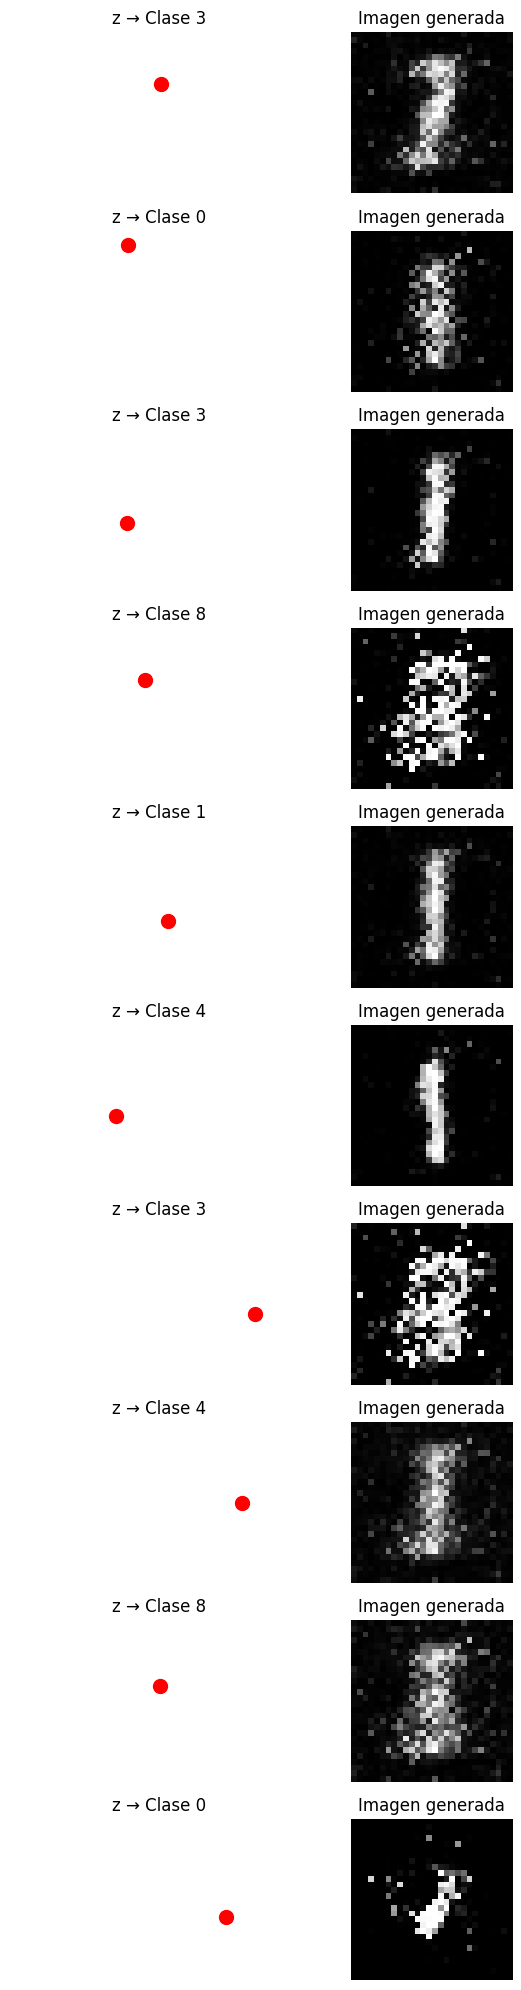

In [ ]:
train_gan(epochs=50)
show_generated_images()
combined_latent_visualization(n_samples=200, n_examples=10)

Epoch 1/100 | D Loss: 0.1104 | G Loss: 5.6285
Epoch 2/100 | D Loss: 0.0496 | G Loss: 7.4598
Epoch 3/100 | D Loss: 0.6699 | G Loss: 9.6693
Epoch 4/100 | D Loss: 0.4892 | G Loss: 1.7069
Epoch 5/100 | D Loss: 1.0141 | G Loss: 0.6305
Epoch 6/100 | D Loss: 0.8174 | G Loss: 1.6423
Epoch 7/100 | D Loss: 0.8231 | G Loss: 0.9061
Epoch 8/100 | D Loss: 0.4700 | G Loss: 2.8916
Epoch 9/100 | D Loss: 0.4481 | G Loss: 1.9995
Epoch 10/100 | D Loss: 0.7320 | G Loss: 2.5662
Epoch 11/100 | D Loss: 0.2769 | G Loss: 2.5059
Epoch 12/100 | D Loss: 0.1545 | G Loss: 2.6156
Epoch 13/100 | D Loss: 0.1660 | G Loss: 3.0027
Epoch 14/100 | D Loss: 0.3788 | G Loss: 2.6071
Epoch 15/100 | D Loss: 0.4007 | G Loss: 4.8331
Epoch 16/100 | D Loss: 0.1702 | G Loss: 3.8904
Epoch 17/100 | D Loss: 0.4641 | G Loss: 3.3683
Epoch 18/100 | D Loss: 0.0841 | G Loss: 3.9967
Epoch 19/100 | D Loss: 0.3147 | G Loss: 3.0776
Epoch 20/100 | D Loss: 0.2711 | G Loss: 2.9057
Epoch 21/100 | D Loss: 0.4281 | G Loss: 4.4291
Epoch 22/100 | D Loss:

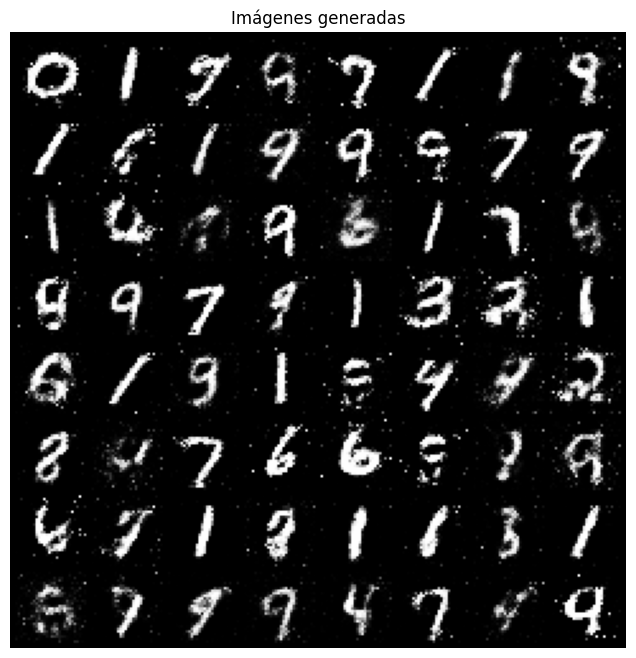

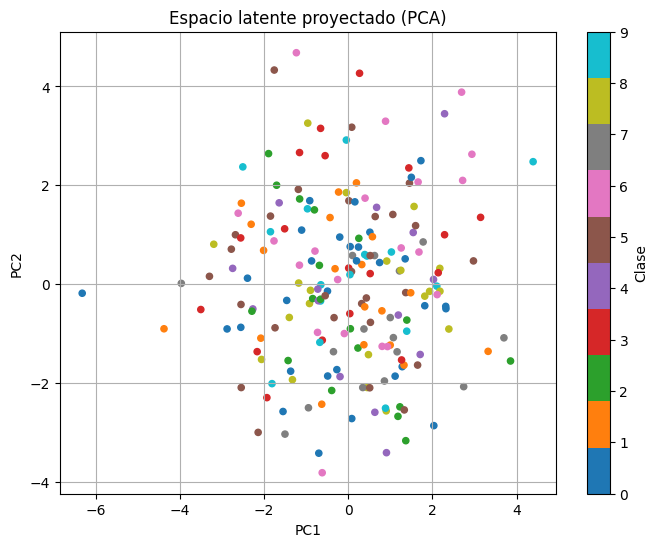

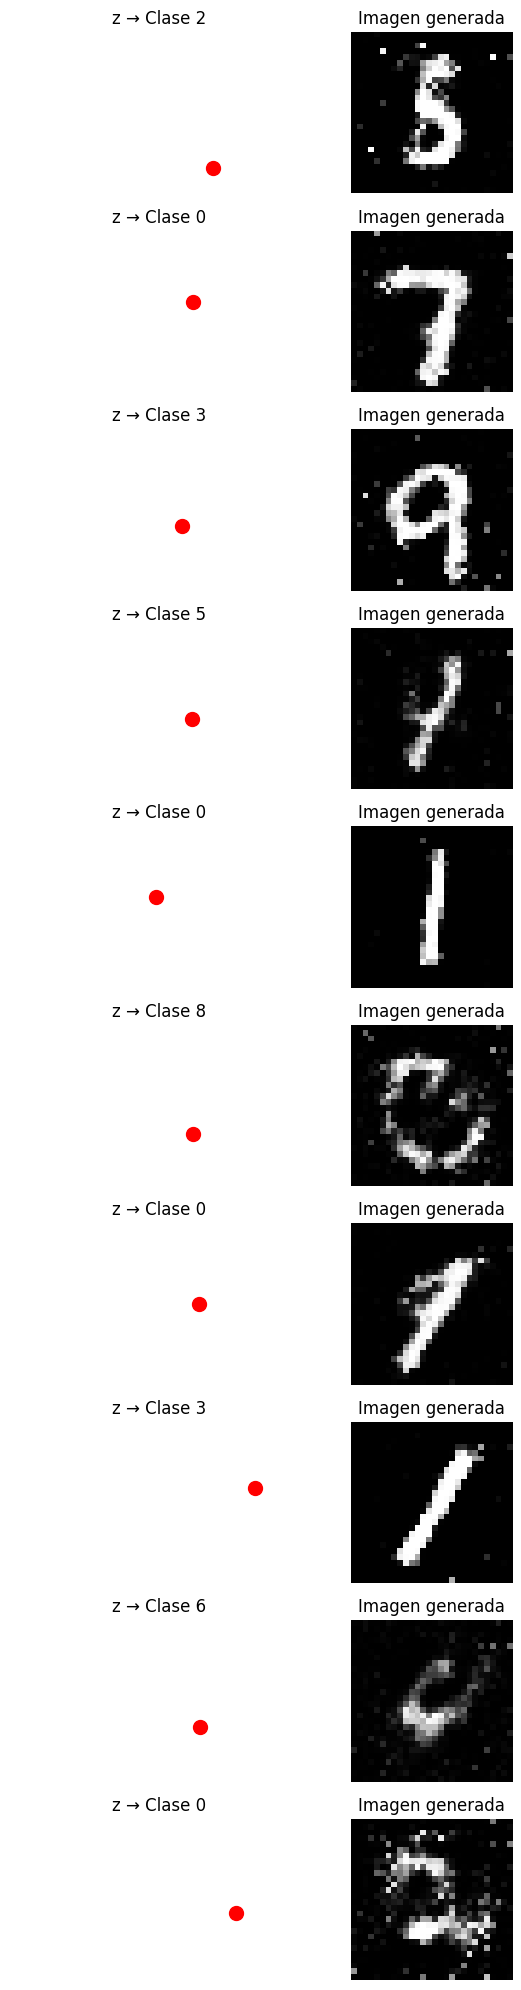

In [ ]:
train_gan(epochs=100)
show_generated_images()
combined_latent_visualization(n_samples=200, n_examples=10)

# Con Hugging Face

## Superresolución

In [ ]:
  from aura_sr import AuraSR
  from PIL import Image
  import requests
  from io import BytesIO

  # Cargar la imagen desde una URL
  def load_image(url):
      response = requests.get(url)
      return Image.open(BytesIO(response.content)).convert("RGB")

  # Inicializar el modelo
  aura_sr = AuraSR.from_pretrained("fal/AuraSR-v2")

  # Cargar y procesar la imagen
  image = load_image("https://example.com/imagen_baja_resolucion.jpg")
  upscaled_image = aura_sr.upscale_4x(image)

  # Guardar la imagen resultante
  upscaled_image.save("imagen_alta_resolucion.jpg")

# Material complementario

* Survey de GANs
https://arxiv.org/pdf/2203.11242

* Tutoriales

https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

https://developers.google.com/machine-learning/gan/gan_structure?hl=es-419

https://huggingface.co/learn/computer-vision-course/en/unit5/generative-models/gans

* Dot CSV

https://youtu.be/YsrMGcgfETY?si=xK5E4vvN2lGvkIRB

https://youtu.be/dPYwr8fihH0?si=cirXf4ugRT1OvUzj


